03/24/2022



We are minimizing the Hamiltonian $H= H_A + H_B = A\left( \sum_{n=1}^N s_i \right)^2 + B \sum_{(u,v) \in E} \frac{1-s_us_v}{2}$

where the first sum $H_A \to 0$ naturally for the minimum solution. 

This solution finds a min-cut colution for $\frac{K(K-1)}{2}$ edges, i.e. all possible edges connecting each point in the graph.

In [1]:
!pip install docplex
!pip install cplex

In [2]:
import numpy as np
import time
import docplex.mp.model as md
import networkx as nx
import matplotlib.pyplot as plt
import random
from scipy.spatial import Delaunay

In [20]:
number_of_points = 4
# Create Data
np.random.seed(0)
x_coord = np.random.randint(0,100,number_of_points)
np.random.seed(1)
y_coord = np.random.randint(0,100,number_of_points)
points=[]
for i in range(number_of_points):
    points.append((x_coord[i],y_coord[i]))

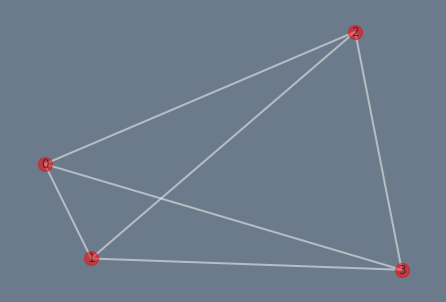

In [21]:
# Generate Graph With Nodes and Edges
G = nx.Graph()
for i in range(number_of_points): 
    G.add_node(i,pos=points[i])
edges=[]
for i in range(number_of_points):
  for j in range(i,number_of_points):
    if i!=j and (j,i) not in edges:
      edges.append((i,j))
    else:
      continue
G.add_edges_from(edges)
fig = plt.figure()
nx.draw(G, pos=nx.get_node_attributes(G,'pos'), with_labels=True, alpha=0.5, node_color='red', edge_color='w',width=2.0,node_size=200)
fig.set_facecolor("#6C7B8B")

In [22]:
start = time.time()
model=md.Model(name='integer_programming')
s=model.integer_var_list(number_of_points,lb=-1,ub=1,name='nodes')
model.add_constraints((s[i] != 0 for i in range(len(s))))
# Calculate Weights
weights=[]
for i,j in G.edges:
  sum=0
  for k in range(len(points[i])):
    sum+=(points[i][k]-points[j][k])**2
  weights.append(np.sqrt(sum))
weights_norm= (weights)/(np.max(weights))
#print(weights_norm)
#weights_norm=1/weights_norm
#weights_norm=(weights_norm)/(np.max(weights_norm))
#print(weights_norm)
####################################################################
# Create Hamiltonian Elements with Weights
weights_docplex=[ np.sum(s)**2+weights_norm[edges.index((i,j))]*(1-s[i]*s[j])/2 for i,j in edges]
###################################################################
model.minimize(np.sum(weights_docplex))
si = model.solve(url=None,key=None)
a=model.solution.get_value_list(s)
a=np.array(a,dtype=int)
time_cplex=time.time()-start
 
print('Solution: ', a)
print('Total Time:' , time_cplex,'s')

Solution:  [-1  0  1 -1]
Total Time: 0.14605116844177246 s


Problem: problem of furthest neighbor pairing in the above when we add weight with all possible edges. The algorithm will naturally want to pair points that are actually the furthest away because $(1-s[i]s[j])*weight \to 0$ in that case, lowering the Hamiltonian value. Possible solutions other than multiply by weights: Divide by weight of each edge, invert normalization of weights and multiply that, multiply by 1-normalization of weights...ALL ADMIT ERRORs

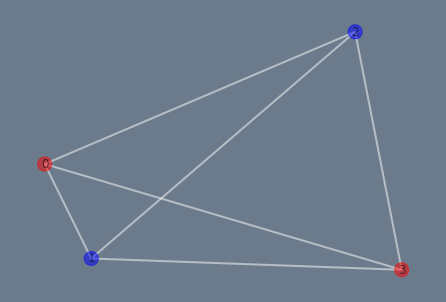

In [23]:
# Plot Solution
# Generate Graph With Nodes and Edges
G2 = nx.Graph()
for i in range(number_of_points): 
    if a[i]==-1:
        G2.add_node(i,pos=points[i],color='red')
    else:
        G2.add_node(i,pos=points[i],color='blue')
colors = [node[1]['color'] for node in G2.nodes(data=True)]
G2.add_edges_from(edges)
fig2 = plt.figure()
nx.draw(G2, pos=nx.get_node_attributes(G2,'pos'), with_labels=True, node_color=colors, edge_color='w', width=2.0,alpha=0.5, node_size=200)
fig2.set_facecolor("#6C7B8B")

NOTW: THIS IS THE MAXCUT SOLUTION, SEE ABOVE FOR ISSUE.

.

.

.

DELAUNEY TRIANGULATIONS SOLUTION: create edges and find a min cut solution. Using Delauney edges takes away the problem of furthest neighbor pairing. NOTE: Even after redefining a new array for the edges, where CPLEX reads the exact same thing as for the max edges solution above, it fails to compute with weights.

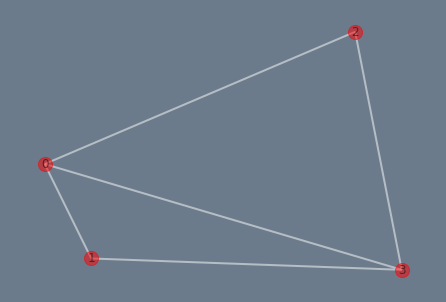

In [24]:
# Generate Graph With Nodes and Edges
G_d = nx.Graph()
for i in range(number_of_points): 
    G_d.add_node(i,pos=points[i])
edges_d=[]
tri = Delaunay(points)
for i in range(len(tri.simplices)):
    for j in range(3):
        edges_d.append((tri.simplices[i][j],tri.simplices[i][j+1]) if j!=2 else (tri.simplices[i][j],tri.simplices[i][0]))
G_d.add_edges_from(edges_d)
# Create a new array with explicit edges copied from G.edges as edges
# has duplicates and is out of order
new_edges=[]
for i,j in G_d.edges:
  new_edges.append((i,j))
fig = plt.figure()
nx.draw(G_d, pos=nx.get_node_attributes(G_d,'pos'), with_labels=True, alpha=0.5, node_color='red', edge_color='w',width=2.0,node_size=200)
fig.set_facecolor("#6C7B8B")

In [25]:
start = time.time()
model=md.Model(name='integer_programming')
s=model.integer_var_list(number_of_points,lb=-1,ub=1,name='nodes')
model.add_constraints((s[i] != 0 for i in range(len(s))))
# Calculate Weights
weight_d=[]
for i,j in G_d.edges:
  sum=0
  for k in range(len(points[i])):
    sum+=(points[i][k]-points[j][k])**2
  weight_d.append(np.sqrt(sum))
weight_norm_d= (weight_d)/(np.max(weight_d))
#Create Hamiltonian Elements with Weights
#weights_docplex_d=[ np.sum(s)**2+weight_norm_d[new_edges.index((i,j))]*(1-s[i]*s[j])/2 for i,j in G_d.edges]
weights_docplex_d=[ np.sum(s)**2+(1-s[i]*s[j])/2 for i,j in G_d.edges]
model.minimize(np.sum(weights_docplex_d))
si = model.solve(url=None,key=None)
a_d=model.solution.get_value_list(s)
a_d=np.array(a_d,dtype=int)
time_cplex=time.time()-start
 
print('Solution: ', a_d)
print('Total Time:' , time_cplex,'s')

Solution:  [-1  1 -1  1]
Total Time: 0.03446841239929199 s


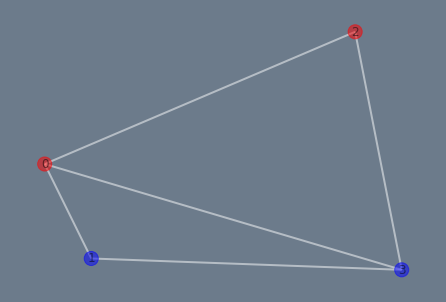

In [26]:
# Plot Solution
# Generate Graph With Nodes and Edges
G2_d = nx.Graph()
for i in range(number_of_points): 
    if a_d[i]==-1:
        G2_d.add_node(i,pos=points[i],color='red')
    else:
        G2_d.add_node(i,pos=points[i],color='blue')
colors = [node[1]['color'] for node in G2_d.nodes(data=True)]
G2_d.add_edges_from(new_edges)
fig2 = plt.figure()
nx.draw(G2_d, pos=nx.get_node_attributes(G2_d,'pos'), with_labels=True, node_color=colors, edge_color='w', width=2.0,alpha=0.5, node_size=200)
fig2.set_facecolor("#6C7B8B")

.

.

.

.

Manual Solution

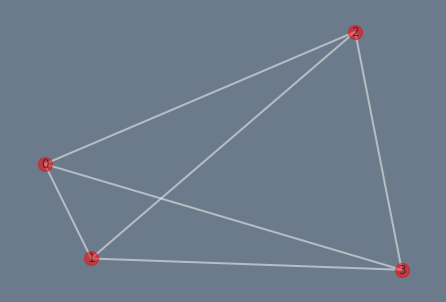

In [27]:
# Generate Graph With Nodes and Edges
G_m = nx.Graph()
for i in range(number_of_points): 
    G_m.add_node(i,pos=points[i])
edges_m=[]
for i in range(number_of_points):
  for j in range(i,number_of_points):
    if i!=j and (j,i) not in edges_m:
      edges_m.append((i,j))
    else:
      continue
G_m.add_edges_from(edges_m)
fig = plt.figure()
nx.draw(G_m, pos=nx.get_node_attributes(G_m,'pos'), with_labels=True, alpha=0.5, node_color='red', edge_color='w',width=2.0,node_size=200)
fig.set_facecolor("#6C7B8B")

In [28]:
import itertools
spins=[]
for i in range(-1,2,2):
  spins.append(i)
combinations = list(map(list, itertools.product(spins, repeat=number_of_points)))
reduced_combinations=[]
for i in range(len(combinations)):
  if np.sum(combinations[i])==0:
    my_new_combination = [j*(-1) for j in combinations[i]]
    if my_new_combination in reduced_combinations:
      continue
    else:
      reduced_combinations.append(combinations[i])
  else:
    continue
rc = reduced_combinations
weights_m=[]
for i,j in G_m.edges:
  sum=0
  for k in range(len(points[i])):
    sum+=(points[i][k]-points[j][k])**2
  weights_m.append(np.sqrt(sum))
weights_norm_m= (weights_m)/(np.max(weights_m))
weights_norm_m=1/weights_norm_m
invert_weights_norm_m=(weights_norm_m)/(np.max(weights_norm_m))
hamiltonian=[]
for i in range(len(rc)):
  hamiltonian.append(np.sum([invert_weights_norm_m[edges_m.index((j,k))]*(1-rc[i][j]*rc[i][k])/2 for j,k in G_m.edges]))
index_of_solution=hamiltonian.index(np.min(hamiltonian))
solution=rc[index_of_solution]
print('Solution: ',solution)

Solution:  [-1, 1, -1, 1]


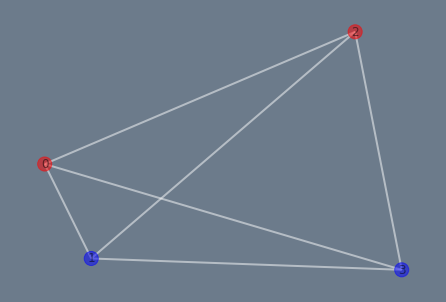

In [29]:
# Plot Solution
# Generate Graph With Nodes and Edges
G2_m = nx.Graph()
for i in range(number_of_points): 
    if solution[i]==-1:
        G2_m.add_node(i,pos=points[i],color='red')
    else:
        G2_m.add_node(i,pos=points[i],color='blue')
colors = [node[1]['color'] for node in G2_m.nodes(data=True)]
G2_m.add_edges_from(edges_m)
fig4 = plt.figure()
nx.draw(G2_m, pos=nx.get_node_attributes(G2_m,'pos'), with_labels=True, node_color=colors, edge_color='w', width=2.0,alpha=0.5, node_size=200)
fig4.set_facecolor("#6C7B8B")